# News Headlines Analysis & Text Mining
Data Info:

*This contains data of news headlines published over a period of 15 years. From the reputable Australian news source ABC (Australian Broadcasting Corp.).* [source](https://www.kaggle.com/therohk/million-headlines)

Site: http://www.abc.net.au/

*Prepared by Rohit Kulkarni*

**My work on this is to analyze two columns (publish dates, headlines) as much as I can. Using plots and tables in order to exract useful information and insights. Some name entities recognition (NER),combining with wordclouds, are used to explore better the headlines. Finaly we will see if there are any similar headlines through years!**

In [1]:
# load all libraries we need here
import pandas as pd
import numpy as np
from collections import Counter
import re
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from string import punctuation
import pickle

In [2]:
# Problem with SpaCy in mac OS X ?
# export LC_ALL=en_US.UTF-8
# export LANG=en_US.UTF-8
# source ~/.bash_profile
# or in iTerm going to the menu:
# Preferences -> Profiles -> Terminal -> (Environment) and then unchecking"Set locale variables automatically"

import spacy

In [3]:
import en_core_web_sm as en

In [4]:
nlp = en.load()

In [5]:
#  load data from csv and parse date column
df = pd.read_csv('abcnews-date-text.csv', parse_dates=[0], infer_datetime_format=True)

In [6]:
# change columns names
df.columns = ['date', 'text']

In [7]:
# create a column with length of headline
df['length'] = df.text.apply(lambda x: len(x.split(" ")))

In [8]:
print('min number of words:', df.length.min(),' ', 'max number of words:', df.length.max())

min number of words: 1   max number of words: 15


In [9]:
# one-word headlines

# a sample of 10 headlines
print(df.loc[df.length == 1].sample(n =10))
print('Number of "in one word" headlines:',df.loc[df.length == 1, ['text']].count())

             date        text  length
660719 2011-12-16       razer       1
235999 2006-05-11     closer1       1
594573 2011-02-15  faridegypt       1
348943 2007-12-07      closer       1
982480 2015-09-22      mining       1
284565 2007-02-08      closer       1
271657 2006-12-04      amazed       1
705413 2012-06-29        iris       1
596517 2011-02-22       lewis       1
983725 2015-09-28        mono       1
Number of "in one word" headlines: text    1358
dtype: int64


In [10]:
# big headlines

print('Number of headlines:',df.loc[df.length == 15, ['text']].count()[0])
print()
# print the complete string
with pd.option_context('display.max_colwidth', 100):
    print (df.loc[df.length == 15]['text'])


Number of headlines: 3

814580     govt sets up a new board to tell it how to buy local gooods and
1030666          no bull a cow a pony and a donkey walk to a pub one night
1068198    gas prices will rise and there is not much we can do to stop it
Name: text, dtype: object


In [11]:
# average number of daily headlines
print('average:',round(df.date.value_counts().mean(),2), 'headlines','\n')

# days with the biggest number of publishments
print('busy days','\n', df.date.value_counts()[:10],'\n')

# days with the smallest number of publishments
print('kinda loosely days','\n',df.date.value_counts()[-10:])

average: 203.55 headlines 

busy days 
 2012-08-24    384
2013-04-12    384
2011-02-22    380
2013-05-14    380
2013-04-16    379
2012-10-17    379
2012-08-14    379
2012-10-23    377
2013-03-28    377
2012-08-01    377
Name: date, dtype: int64 

kinda loosely days 
 2006-11-04    21
2015-01-06    21
2006-10-28    21
2015-01-09    21
2006-11-05    21
2015-01-11    19
2006-09-02    19
2015-01-18    19
2015-01-10    19
2015-01-17    18
Name: date, dtype: int64


I have an intuition for these two results. All I want to say is, I believe that busy days and loosly days are not random but they got their own significance. I gonna verify my instict...

In [12]:
# 0 : Monday, ... , 6 : Sunday

for i in ['2012-08-24','2013-04-12','2011-02-22','2012-10-23']:
    x = df.loc[df.date == i].index[0]
    print(df.date[x].dayofweek)

4
4
1
1


In [13]:
for i in ['2006-11-04','2015-01-06','2006-09-02','2015-01-17']:
    x = df.loc[df.date == i].index[0]
    print(df.date[x].dayofweek)

5
1
5
5


We see (from a random sample) that Fridays(4) and Tuesdays(1) are busy days and weekend days like Saturaday(5) are more loosly in publishments. We will do a plot in the lines below to confirm this!

/Users/stephanosarampatzes/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


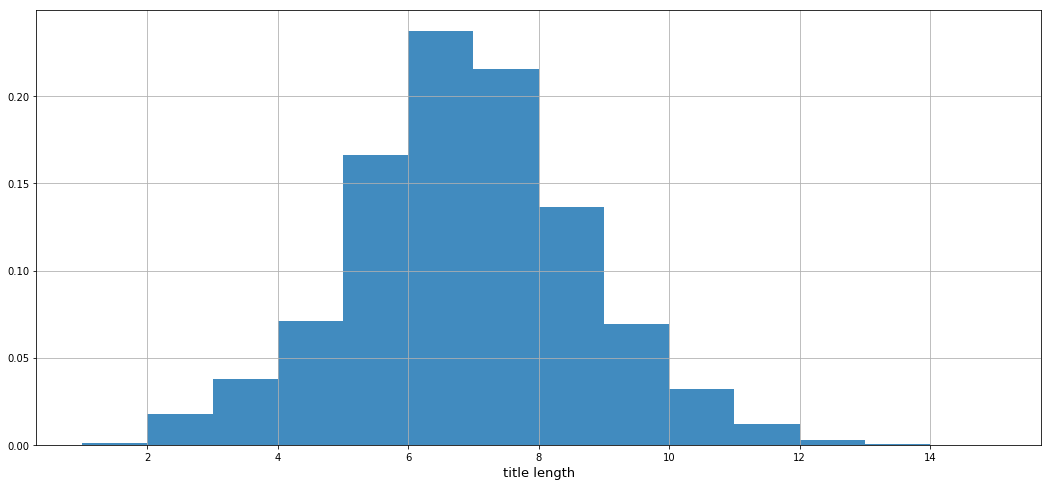

In [14]:
fig, ax = plt.subplots(figsize = (18, 8))
plt.hist(df.length, bins = range(1,16), normed = 1, alpha=0.85)
plt.xlabel('title length', fontsize =13)
plt.grid(True)
plt.show()

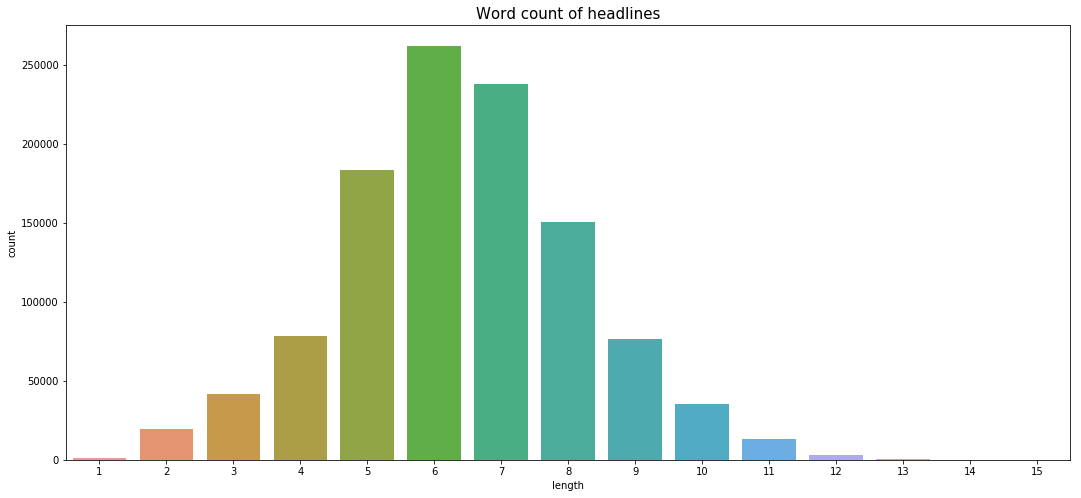

In [15]:
fig, ax = plt.subplots(figsize = (18, 8))
sns.countplot(df.length)
plt.title('Word count of headlines', fontsize = 15)
plt.show()

Most of headlines have 6 or 7 words, so they got to be comprehensive. By the way this seems to me like a normal distribution though... a few more dist. plots below!

/Users/stephanosarampatzes/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


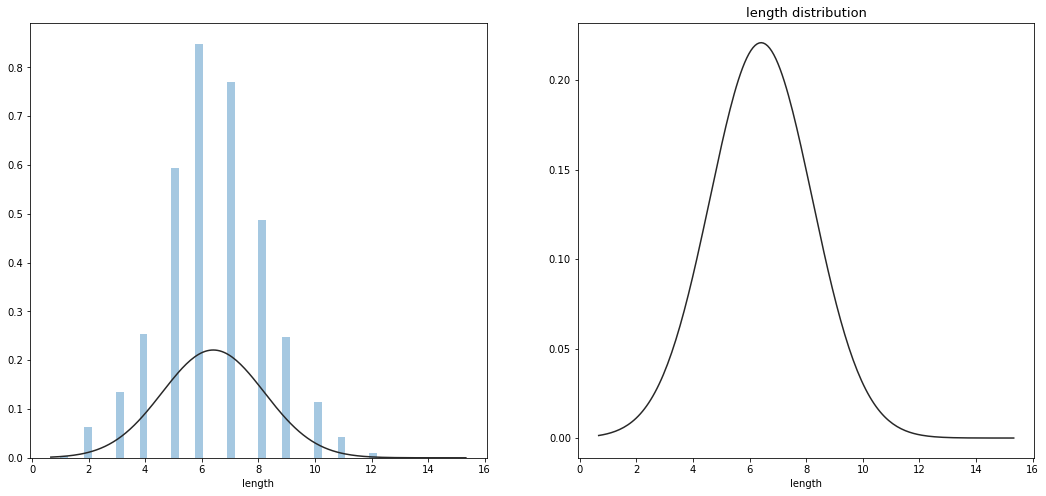

In [16]:
from scipy.stats import norm
fig, ax = plt.subplots(figsize = (18, 8))
plt.subplot(1,2,1)
sns.distplot(df.length, fit = norm, kde = False)
plt.subplot(1,2,2)
sns.distplot(df.length, fit = norm, kde = False, hist = False)
plt.title('length distribution', fontsize =13)
plt.show()


There is a tiny **positive skew** in this right skewed distribution (I used the whole dataset and not sample). Let's take a sample of 100K data points and check once again the skewness!!

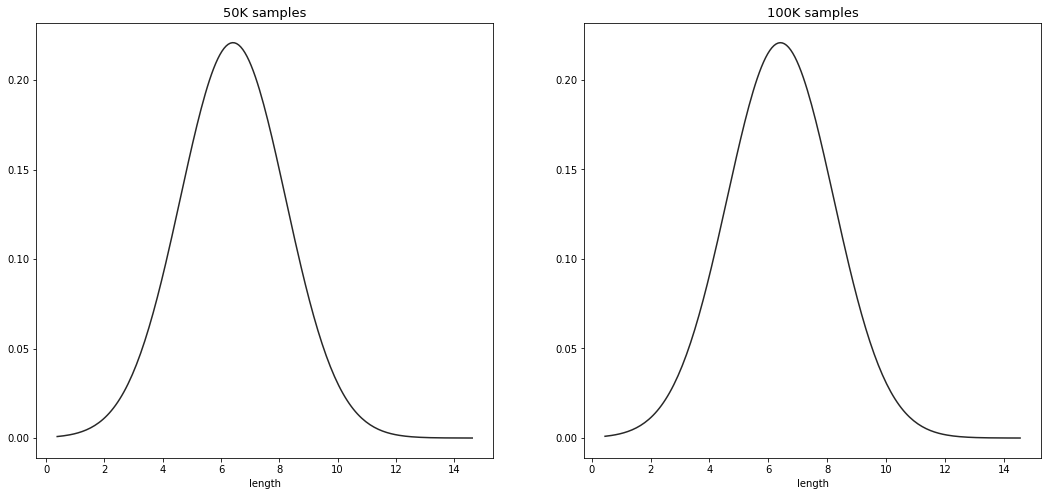

In [17]:
fig, ax = plt.subplots(figsize = (18, 8))
plt.subplot(1,2,1)
sns.distplot(df.length.sample(n = 50000),fit= norm , kde = False, hist = False)
plt.title('50K samples', fontsize =13)
plt.subplot(1,2,2)
sns.distplot(df.length.sample(n = 100000),fit= norm, kde = False, hist = False)
plt.title('100K samples', fontsize =13)
plt.show()

There are no outliers. There are headlines with 15 words as we did see above. So the positive skew is real.

/Users/stephanosarampatzes/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


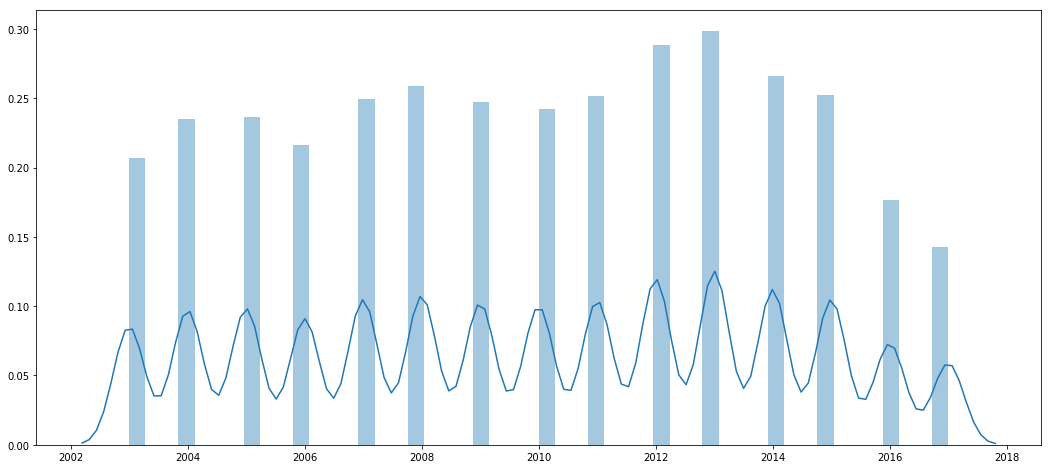

In [18]:
# year series
fig, ax = plt.subplots(figsize = (18, 8))
sns.distplot([y.year for y in df.date])
plt.show()

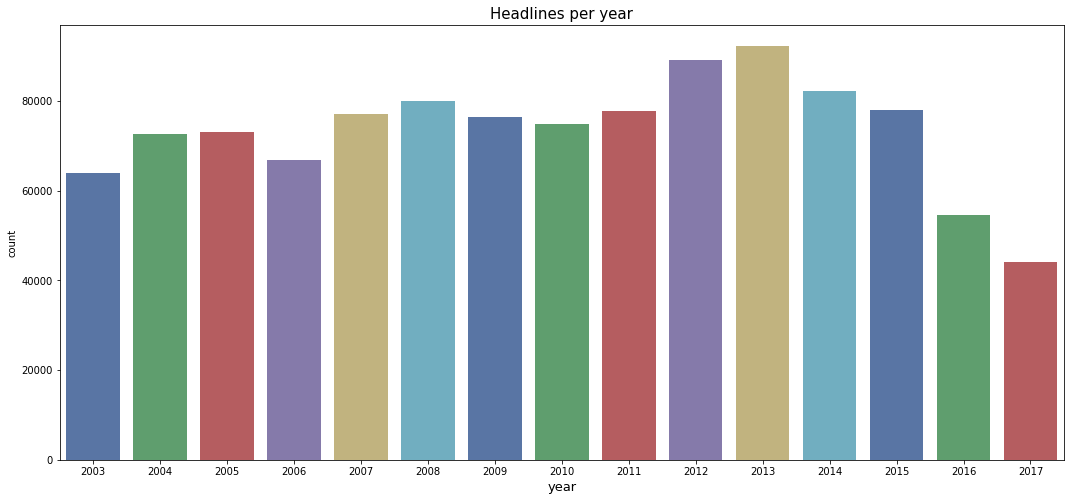

In [19]:
fig, ax = plt.subplots(figsize = (18, 8))
sns.countplot([y.year for y in df.date], palette = 'deep')
plt.xlabel('year', fontsize =13)
plt.title('Headlines per year', fontsize = 15)
plt.show()

Years 2012 and 2013 were productive ones. However 2017 is a bad year for ABCnews.

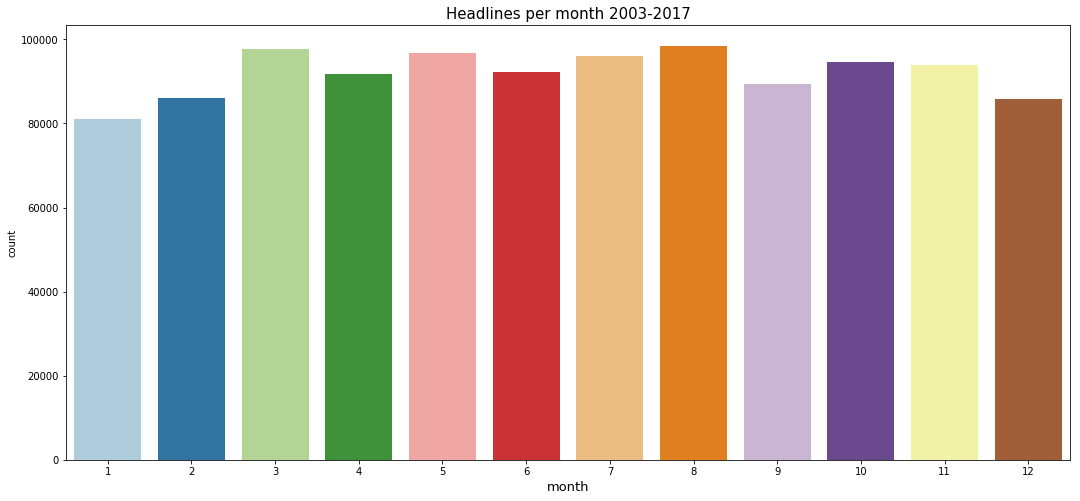

In [20]:
fig, ax = plt.subplots(figsize = (18, 8))
sns.countplot([m.month for m in df.date], palette = 'Paired')
plt.xlabel('month', fontsize =13)
plt.title('Headlines per month 2003-2017', fontsize = 15)
plt.show()

At the begining and the fall of every year we got low publishment frequency! Maybe the reason is Christmas and New Year Eve!

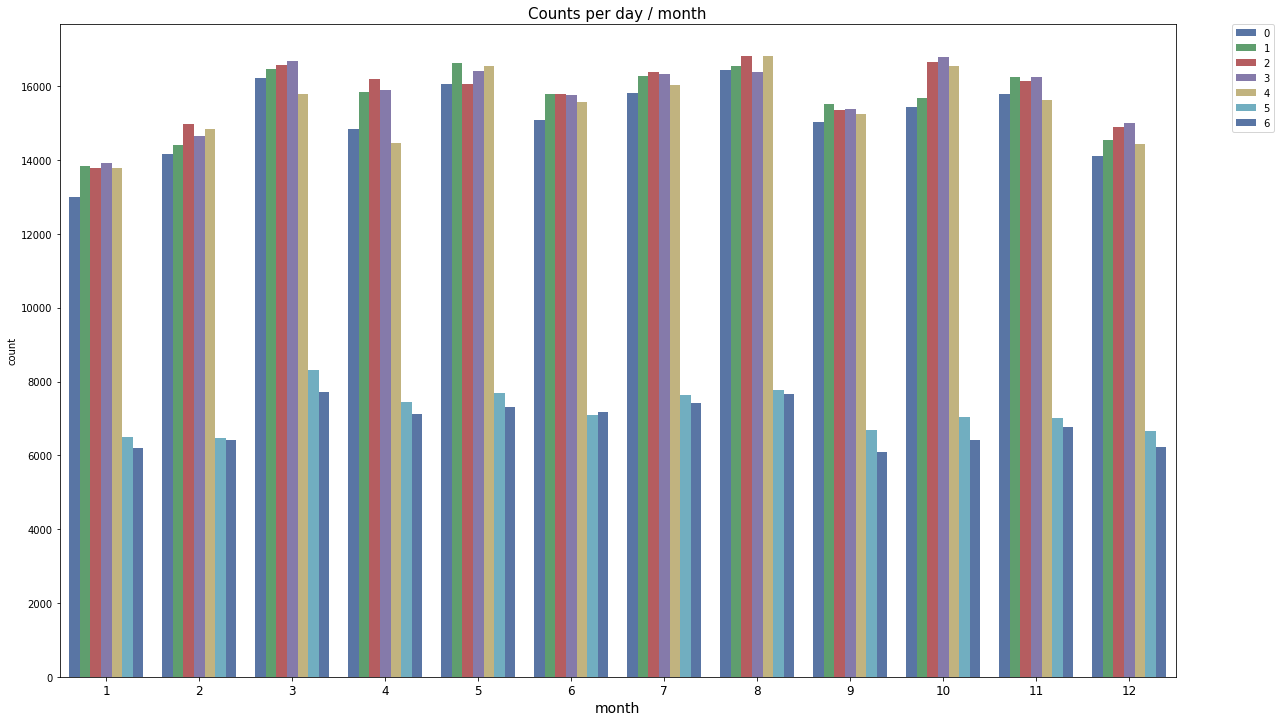

In [21]:
fig, ax = plt.subplots(figsize = (20, 12))
sns.countplot([m.month for m in df.date], hue = df.date.apply(lambda x: x.dayofweek),palette = 'deep')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('month', fontsize = 14)
plt.xticks(fontsize = 12)
plt.title('Counts per day / month', fontsize = 15)
plt.show()

I did say that weekends are loosly days and not busy ones. This plot verifies my initial intuition! There is a lot of traffic at the middle of the week, Wednesday - Friday !

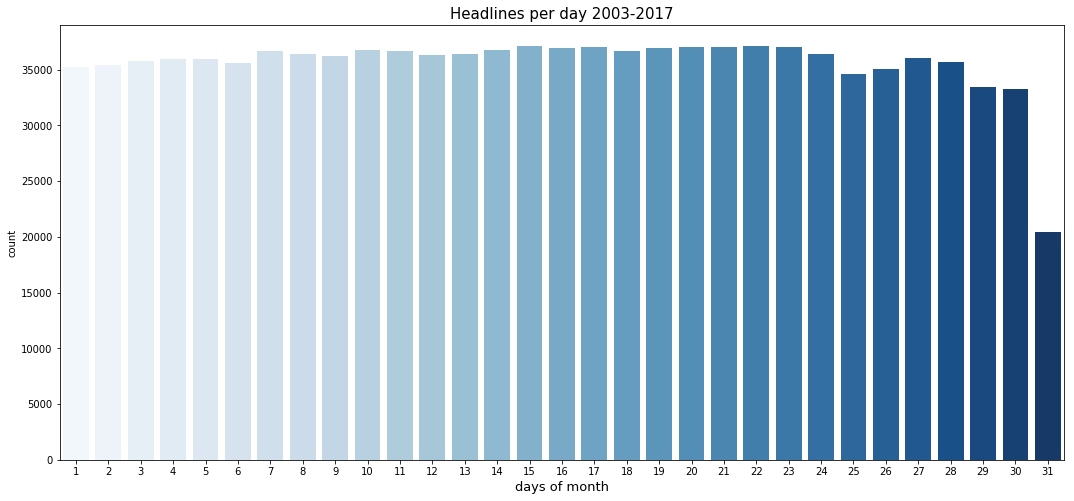

In [22]:
fig, ax = plt.subplots(figsize = (18, 8))
sns.countplot([d.day for d in df.date], palette = 'Blues')
plt.xlabel('days of month', fontsize = 13)
plt.title('Headlines per day 2003-2017', fontsize = 15)
plt.show()

One more

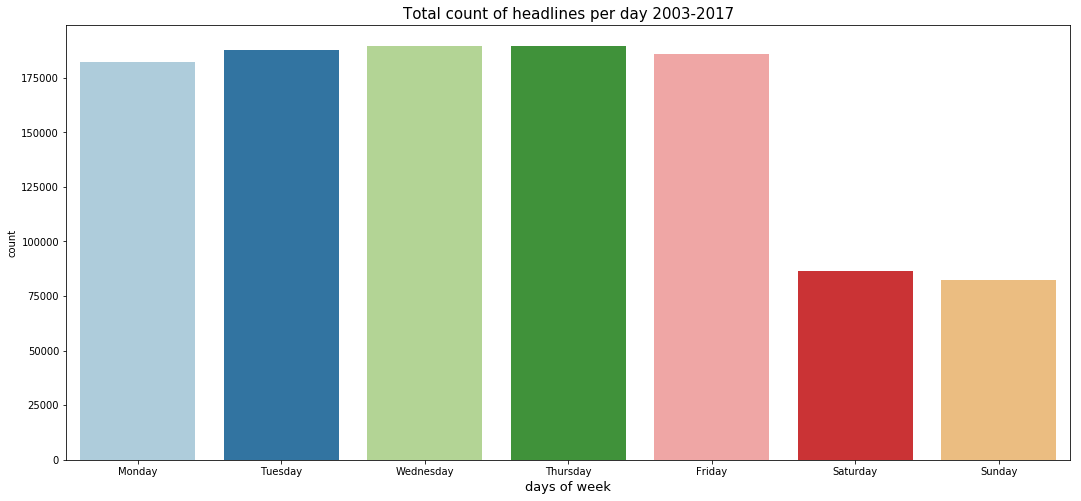

In [23]:
fig, ax = plt.subplots(figsize = (18, 8))
labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.countplot([dow.dayofweek for dow in df.date], palette = 'Paired')
ax.set_xticklabels(labels)
plt.xlabel('days of week', fontsize = 13)
plt.title('Total count of headlines per day 2003-2017', fontsize = 15)
plt.show()

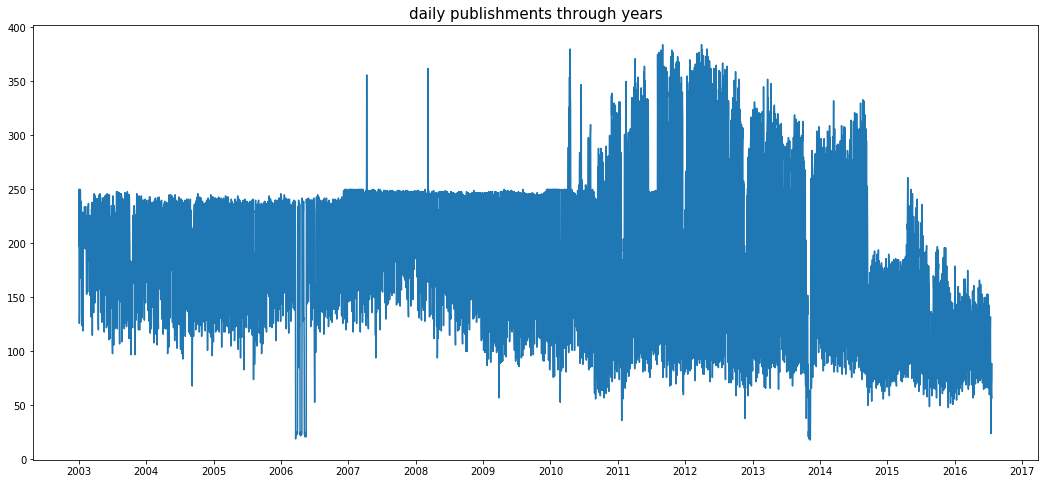

In [24]:
# a publishment "cardiogram"

df['year'] = df.date.apply(lambda x: x.year)

df['month'] = df.date.apply(lambda x: x.month)

df['day'] = df.date.apply(lambda x: x.day)

# plot
fig, ax = plt.subplots(figsize = (18, 8))
ax.plot(df.groupby(['year','month','day']).count().reset_index()['text'])
ax.xaxis.set_major_locator(plt.MaxNLocator(15))
ax.set_xticklabels([y for y in range(2002,2018,1)])
plt.title('daily publishments through years', fontsize = 15)
plt.show()

### Name Entities Recognition (NER)

In [25]:
# get a sample of 100K rows
sample = df.sample(n = 100000).reset_index()

In [26]:
# Tokenizer

def tokenizer(headline):
    headline = re.sub('[^a-zA-Z0-9]', ' ', headline)
    tokens = nlp(headline)
    tokens = [t.lemma_.strip() if t.lemma_ != 'PRON' else t.lower_ for t in tokens]
    tokens = [t for t in tokens if t not in set(list(ENGLISH_STOP_WORDS) + list(punctuation))]
    tokens = [t for t in tokens if len(t)>=2]
    return(tokens)

This operation takes a little more time to be done. So I did save it as pickle file to gain more time!

I did generate tokens in Spyder(Anaconda) and I used a pickle file to store them. Just load the 'sample_df' file.

In [ ]:
# apply tokenizer on every row to extract tokens from headlines
sample['tokens'] = sample.headline_text.apply(lambda x: tokenizer(x))

In [ ]:
# save as pickle
sample.to_pickle('sample_df')

In [28]:
# load pickle file
sample_pkl = pd.read_pickle('sample_df')

In [29]:
print(sample_pkl.columns,'\n\n', sample_pkl.dtypes)

Index(['index', 'publish_date', 'headline_text', 'tokens'], dtype='object') 

 index                     int64
publish_date     datetime64[ns]
headline_text            object
tokens                   object
dtype: object


Extract entities with SpaCy [NER](https://spacy.io/api/entityrecognizer) API.

In [30]:
# NER function
def ner(toks):
    ent = nlp(toks)
    ent = [(e.text, e.label_) for e in ent.ents]
    return(ent)

ents = []

for i in range(0,len(sample_pkl)):
    ents.append(ner(sample_pkl.headline_text[i]))

I had to be patient for this one... wish I had better hardware :)

Going further, I do want to collect two entities from headlines: 'Person' names and geographical areas!

In [31]:
# collect entities for persons and geogrphical regions

def collect_ents(tag, list_name):
    for i in range(0,len(ents)):
        if ents[i] == []:
            pass
        elif ents[i][0][1] == tag:
            list_name.append(ents[i][0][0])

geo = [] # "GPE"
persons = [] #"PERSON"

In [32]:
collect_ents('GPE', geo)
collect_ents('PERSON', persons)

In [33]:
# top counts of GPE's
Counter(geo).most_common(30)

[('china', 400),
 ('india', 233),
 ('japan', 176),
 ('iraq', 119),
 ('vietnam', 65),
 ('london', 41),
 ('malaysia', 30),
 ('california', 29),
 ('egypt', 25),
 ('tokyo', 11),
 ('mexico', 11),
 ('russia', 8),
 ('florida', 7),
 ('korea', 6),
 ('israel', 5),
 ('mexico city', 4),
 ('kuwait', 3),
 ('moscow', 3),
 ('mh17', 3),
 ('cuba', 3),
 ('houston', 3),
 ('zimbabwe', 3),
 ('tr4', 2),
 ('stockholm', 2),
 ('mid west', 1),
 ('gaza', 1),
 ('chicago', 1),
 ('c&k', 1),
 ('washington', 1),
 ('abc2', 1)]

In [34]:
# top counts of persons
Counter(persons).most_common(30)

[('al', 14),
 ('jack', 6),
 ('elizabeth', 3),
 ('100th', 2),
 ('j1407b', 1),
 ('117th', 1),
 ('sbs2', 1),
 ('s5ep02', 1),
 ('clinton', 1),
 ('m4', 1),
 ('sharon', 1),
 ('400th', 1),
 ('ps4', 1),
 ('abby', 1),
 ('robert', 1),
 ('m2', 1),
 ('27el', 1),
 ('9yo', 1),
 ('kim', 1),
 ('170th', 1),
 ('250th', 1)]

In [35]:
### WHAT IS 'AL' ?

print("number of texts contain 'al qa':",df.loc[df.text.str.contains('al qa'), ['text']].count()[0],'\n')
df.loc[df.text.str.contains('al qa'), ['text','date']].sample(n=10)

number of texts contain 'al qa': 708 



,text,date
306902,spies warned white house on al qaeda rise in iraq,2007-05-26
614789,al qaedas new leader named,2011-05-19
906381,bangladesh police arrest al qaeda suspects,2014-09-26
3210,yemeni citizens charged with supporting al qaeda,2003-03-05
51381,govt defends al qaeda suspect probe,2003-10-27
181755,pm reserves judgement on al qaeda video,2005-08-12
767540,one eyed al qaeda commander belmokhtar reporte...,2013-03-03
282570,turkey arrests 46 al qaeda suspects,2007-01-29
118247,hackers attack al qaeda linked websites,2004-09-29
79893,al qaeda deputy sought support in new zealand,2004-03-22


It's obviously Al Qaeda. 2003 starts the war at Iraq and Afghanistan. The upcoming years, news from the middle east war are coming up in high frequency!

In [36]:
# buzz words
# var as a string

buzz_list = ['terror','crime','gun','obama','tsunami','shark']

def buzz_words(word):
    print()
    print(word,'5 random headlines below:','\n\n',df.loc[df.text.str.contains(word), ['text','date']].sample(n=5))
    print('total number of headlines:')
    return(df.loc[df.text.str.contains(word),['text'][0]].count())


In [37]:
for i in buzz_list:
    print(buzz_words(i))


terror 5 random headlines below: 

                                                      text       date
342912                   nz terrorism laws under scrutiny 2007-11-09
230668                 libya remains on us terrorism list 2006-04-14
986757  18 year old held since sydney terror raids rem... 2015-10-12
127001       us lowers terrorism alert level for new york 2004-11-11
947338  police apply to hold teen over alleged anzac d... 2015-04-19
total number of headlines:
3896

crime 5 random headlines below: 

                                                      text       date
216953                     sa to tackle youth crime cycle 2006-02-06
612411          elderly nz crimefighter told to stay home 2011-05-07
613751             police to target alcohol fuelled crime 2011-05-13
855050       hundreds bear witness to north koreas crimes 2014-02-18
892349  un launches probe into alleged israeli war cri... 2014-07-24
total number of headlines:
3228

gun 5 random headlines below: 

  

Australia is really famous for shark attacks...

In [38]:
gpes = ' '.join(geo)
prs = ' '.join(persons)

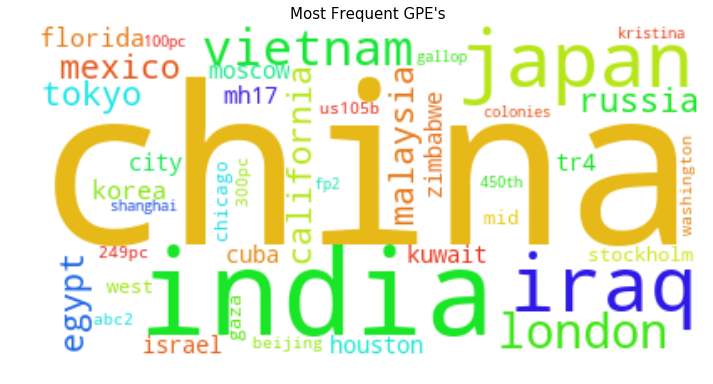

In [39]:
# wordcloud for GPEs
wordcloud = WordCloud(background_color="white").generate(gpes)
plt.figure(figsize = (12, 10))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.title("Most Frequent GPE's", fontsize = 15)
plt.axis("off")
plt.show()

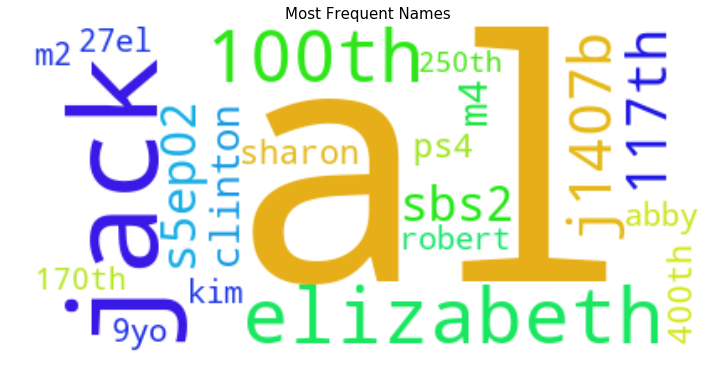

In [40]:
# wordcloud for PERSONS
wordcloud = WordCloud(background_color="white").generate(prs)
plt.figure(figsize = (12, 10))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.title('Most Frequent Names', fontsize = 15)
plt.axis("off")
plt.show()

In [41]:
# unknown GPE's
with pd.option_context('display.max_colwidth', 100):
    print(sample_pkl.loc[sample_pkl.headline_text.str.contains('mh17'), ['headline_text']])

                                                       headline_text
12645  australian honeymooners changed flight ahead of malaysia mh17
13067                      malaysia airlines mh17 australian victims
15926      fragments from mh17 site may be from russian made missile
16267         russia australia relationship frosty since mh17 crimea
17051                      local authorities abandon mh17 crash site
17118               mh17 trial would see justice says son of victims
18124    mh17 queensland deaths family hit by both malaysian crashes
20423                            nsw victim of mh17 was catholic nun
23794              malaysia airlines to be privatised following mh17
45043     german student and mh17 victim dreamt of new life in perth
50657          mh17 one of australia's worst ever overseas disasters
53351     abbott says recovering bodies of mh17 victims top priority
59628                mh17 video explains planes flight over conflict
66953  newcastle cathedral to host

*Malaysia Airlines Flight 17 (MH17/MAS17)[a] was a scheduled passenger flight from Amsterdam to Kuala Lumpur that was shot down on 17 July 2014 while flying over eastern Ukraine [..].*

[source](https://en.wikipedia.org/wiki/Malaysia_Airlines_Flight_17) (Wikipedia)

In [42]:
# Tropical race 4 (TR4) is the name given to the strains of the fungus Fusarium oxysporum

with pd.option_context('display.max_colwidth', 100):
    print(sample_pkl.loc[sample_pkl.headline_text.str.contains('tr4'), ['headline_text']])


                                                          headline_text
313    steve lizzio says banana growers can bounce back from panama tr4
53722   lindsay transports terry montague talks about panama tr4 threat
87993        bevan robson and doug phillips on panama tr4 banana buyout


*Panama disease is a plant disease of the roots of banana plants. It is a type of Fusarium wilt, caused by the fungal pathogen Fusarium oxysporum f. sp. cubense (Foc).*

[source](https://en.wikipedia.org/wiki/Panama_disease) (Wikipedia)


We can do the same work for several entities. However in 'persons' list there are irrelevant entities like 'j1407b'. Which is a name of a star discovered by Eric Mamajek.

## Similarities

We gonna find similar pairs of headlines, published in different dates. This is based on [cosine similarity](https://en.wikipedia.org/wiki/Cosine_similarity). *Cosine similarity is a measure of similarity between two non-zero vectors of an [inner product space](https://en.wikipedia.org/wiki/Inner_product_space) that measures the cosine of the angle between them*. In this case these vectors are coming from CountVectorizer. So, the more the angle between these two vectors is close to 0° the more similar these documents are.

<img src='2b4a7a82-ad4c-4b2a-b808-e423a334de6f.png'/>


We can calculate cos(θ) from [dot product](https://en.wikipedia.org/wiki/Dot_product). 

In [43]:
sample_pkl.head()

,index,publish_date,headline_text,tokens
0,767471,2013-03-02,south african police charged with murder,"[south, african, police, charge, murder]"
1,697017,2012-05-22,bhp to begin union negotiations in pilbara,"[bhp, begin, union, negotiation, pilbara]"
2,521500,2010-02-24,council urged to find second fire refuge,"[council, urge, second, refuge]"
3,241837,2006-06-07,western qld mps air mixed views on state budget,"[western, qld, mp, air, mixed, view, state, bu..."
4,906139,2014-09-25,bhp wants an international price on carbon,"[bhp, want, international, price, carbon]"


Comparing hundreds of thousands pairs is time consumng, so, I will select a random sample of 10.000 data points from the initial 100K sample. We just want to find any similarities (if there are any of them) as an example...

In [149]:

resample = sample_pkl.sample(n = 10000).reset_index()

In [167]:
# save sample to pickle
# resample.to_pickle('resample1')

In [151]:
# load 10K sample
# resample = pd.read_csv('resample1.csv')

In [152]:
# take tokens out of list and remove numbers
resample['toks'] = resample.tokens.apply(lambda x: ' '.join(x))
resample['toks'] = resample.toks.apply(lambda x: re.sub('[^a-zA-Z]', ' ', x))
resample['tok_len'] = resample.toks.apply(lambda x: len(x.split(" ")))

In [153]:
resample.head()

,level_0,index,publish_date,headline_text,tokens,toks,tok_len
0,91854,871375,2014-04-29,cattle handling techniques up for debate in th...,"[cattle, handle, technique, debate, territory]",cattle handle technique debate territory,5
1,18188,668026,2012-01-25,i27m not finished yet; says ponting,"[i27, finish, say, pont]",i finish say pont,6
2,69919,349955,2007-12-12,2 fires still out of control on kangaroo is,"[control, kangaroo]",control kangaroo,2
3,71973,136641,2004-12-31,service to farewell canberra tsunami victim,"[service, farewell, canberra, tsunami, victim]",service farewell canberra tsunami victim,5
4,78065,200004,2005-11-11,govt accused of using bullying tactics to force,"[govt, accuse, use, bullying, tactic, force]",govt accuse use bullying tactic force,6


I want the average token length in case I do want to use n_grams. Just to examine the range that it could be a good fit.

In [154]:
resample.tok_len.mean()

5.3346

In [155]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# verify that there are not stop words and remove words with two characters
cv = CountVectorizer(stop_words = 'english', min_df=1)

In [156]:
X = resample.iloc[:,5] 
feats = cv.fit_transform(X)

In [157]:
feats

<10000x9629 sparse matrix of type '<class 'numpy.int64'>'
	with 50035 stored elements in Compressed Sparse Row format>

size: 10000x9629

In [158]:
# convert to dataframe
feats_df = pd.DataFrame(feats.toarray(), columns=cv.get_feature_names())

In [159]:
feats_df.head()

,aagaard,aaron,ab,abalone,abandon,abare,abattoir,abbot,abbott,abc,...,zoo,zorba,zoustar,zuckerberg,zuhbi,zumbo,zurich,zvonereva,zwitkowsky,zygi
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [160]:
# calculate cos θ
# we actually use here feats and not feats_df, but I want a sample from a previous kernel
sims = cosine_similarity(feats)

In [161]:
sims

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [162]:
sims_df = pd.DataFrame(sims)

In [163]:
# sort values by first column
sims_df.sort_values(0, ascending = False)[1:4]

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
368,0.316228,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9733,0.316228,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8247,0.258199,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [164]:
# take 10 first columns and their similarities 
for i in range(0, 11):
    print(i,'is similar with:','\n\n',sims_df.sort_values(i, ascending = False)[1:4][i])
    print()

0 is similar with: 

 368     0.316228
9733    0.316228
8247    0.258199
Name: 0, dtype: float64

1 is similar with: 

 6966    0.408248
9807    0.408248
5917    0.333333
Name: 1, dtype: float64

2 is similar with: 

 2659    0.500000
420     0.408248
7071    0.408248
Name: 2, dtype: float64

3 is similar with: 

 1402    0.600000
4987    0.447214
5190    0.365148
Name: 3, dtype: float64

4 is similar with: 

 4650    0.462910
344     0.408248
8128    0.365148
Name: 4, dtype: float64

5 is similar with: 

 6647    0.5
596     0.5
3513    0.5
Name: 5, dtype: float64

6 is similar with: 

 5210    0.447214
8388    0.353553
6400    0.288675
Name: 6, dtype: float64

7 is similar with: 

 3234    0.400000
2967    0.400000
5133    0.338062
Name: 7, dtype: float64

8 is similar with: 

 8       1.000000
5678    0.666667
6837    0.577350
Name: 8, dtype: float64

9 is similar with: 

 6834    0.316228
796     0.316228
2643    0.316228
Name: 9, dtype: float64

10 is similar with: 

 9800    0.50

In these 10 first columns we got values from 0.4 to 0.67. Of course we can examine the rest 9619 columns, but we will need more time to accomplish it!


Let's take a few pairs, and reveal their headline texts to verify if are similar or not!

In [166]:
# random pairs
for i in [[2,2659], [3,1402], [5,6647], [8,5678],[10,9800]]:
    print('pair:',i)
    display(resample.loc[resample.index == i[0]])
    display(resample.loc[resample.index == i[1]])
    print()

pair: [2, 2659]


,level_0,index,publish_date,headline_text,tokens,toks,tok_len
2,69919,349955,2007-12-12,2 fires still out of control on kangaroo is,"[control, kangaroo]",control kangaroo,2


,level_0,index,publish_date,headline_text,tokens,toks,tok_len
2659,60613,839282,2013-12-03,kangaroos still number one,"[kangaroo, number]",kangaroo number,2



pair: [3, 1402]


,level_0,index,publish_date,headline_text,tokens,toks,tok_len
3,71973,136641,2004-12-31,service to farewell canberra tsunami victim,"[service, farewell, canberra, tsunami, victim]",service farewell canberra tsunami victim,5


,level_0,index,publish_date,headline_text,tokens,toks,tok_len
1402,44769,186140,2005-09-03,service farewells shark attack victim,"[service, farewell, shark, attack, victim]",service farewell shark attack victim,5



pair: [5, 6647]


,level_0,index,publish_date,headline_text,tokens,toks,tok_len
5,24063,237335,2006-05-17,man questioned over melbourne shooting,"[man, question, melbourne, shooting]",man question melbourne shooting,4


,level_0,index,publish_date,headline_text,tokens,toks,tok_len
6647,85943,60314,2003-12-10,man charged over melbourne siege,"[man, charge, melbourne, siege]",man charge melbourne siege,4



pair: [8, 5678]


,level_0,index,publish_date,headline_text,tokens,toks,tok_len
8,22492,527457,2010-03-24,interview andy friend,"[interview, andy, friend]",interview andy friend,3


,level_0,index,publish_date,headline_text,tokens,toks,tok_len
5678,8786,506265,2009-12-10,interview andy otten,"[interview, andy, otten]",interview andy otten,3



pair: [10, 9800]


,level_0,index,publish_date,headline_text,tokens,toks,tok_len
10,69567,311199,2007-06-15,war of word erupts over huskisson building hei...,"[war, word, erupt, huskisson, building, height]",war word erupt huskisson building height,6


,level_0,index,publish_date,headline_text,tokens,toks,tok_len
9800,40948,45908,2003-09-30,war of words erupts over wa timber industry,"[war, word, erupt, wa, timber, industry]",war word erupt wa timber industry,6


Every headline have been published in different date from its similar one! I believe, the headlines are really close regarding the content.


### Epilogue...

From two columns we did succeed to extract the most of information and insights. We did achieve to use at the fullest our data set. Thanks to plots we made a meaningfull story of the ABCnews headlines and considering the name recognition and similar pairs of text, we have a good and enjoyable result! See ya ...